In [88]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch

In [89]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [90]:
from fastai.text.all import *

In [91]:
path = untar_data(URLs.WIKITEXT_TINY)
path.ls()

(#2) [Path('/home/adnathan/.fastai/data/wikitext-2/test.csv'),Path('/home/adnathan/.fastai/data/wikitext-2/train.csv')]

In [92]:
df_train = pd.read_csv(path/'train.csv', header=None)
df_valid = pd.read_csv(path/'test.csv', header=None)
df_train.head()

,0
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z..."
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re..."
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit..."
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch..."
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ...."


In [93]:
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])


In [94]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [95]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

Token indices sequence length is longer than the specified maximum sequence length for this model (4576 > 1024). Running this sequence through the model will result in indexing errors


In [96]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [97]:
dls.show_batch(max_n=2)

,text,text_
0,"\n = Art in Medieval Scotland = \n \n Art in Medieval Scotland includes all forms of artistic production within the modern borders of Scotland , between the fifth century and the adoption of the Renaissance in the early sixteenth century . In the early Middle Ages , there were distinct material cultures evident in the different federations and kingdoms within what is now Scotland . Pictish art was the only uniquely Scottish Medieval style ; it can be seen in the extensive survival of carved stones , particularly in the north and east of the country , which hold a variety of recurring images and patterns . It can also be seen in elaborate metal work that largely survives in buried <unk> . Irish @-@ Scots art from the kingdom of Dál Riata suggests that it was one of the places , as a crossroads between cultures ,","\n = Art in Medieval Scotland = \n \n Art in Medieval Scotland includes all forms of artistic production within the modern borders of Scotland , between the fifth century and the adoption of the Renaissance in the early sixteenth century . In the early Middle Ages , there were distinct material cultures evident in the different federations and kingdoms within what is now Scotland . Pictish art was the only uniquely Scottish Medieval style ; it can be seen in the extensive survival of carved stones , particularly in the north and east of the country , which hold a variety of recurring images and patterns . It can also be seen in elaborate metal work that largely survives in buried <unk> . Irish @-@ Scots art from the kingdom of Dál Riata suggests that it was one of the places , as a crossroads between cultures , where"
1,"and Saigon would have to look beyond personalities . \n Angry with Deepe for airing Khánh 's grievances against him , Taylor invited every other US journalist in Saigon to this private briefing . Taylor gave the journalists his account of the dispute and discussions with the generals , and hoped it would be useful background information for the media , so they would understand what he had done and not reach negative conclusions about his conduct in their writing . Due to the sensitivity of the situation , he asked them to keep the remarks off the record . However , someone at the briefing informed Deepe of what Taylor had said , and she published the remarks on December 25 under the title "" Taylor <unk> Mask Off Khánh "" . In this article , comments were also attributed to Taylor describing some South Vietnamese officers as","Saigon would have to look beyond personalities . \n Angry with Deepe for airing Khánh 's grievances against him , Taylor invited every other US journalist in Saigon to this private briefing . Taylor gave the journalists his account of the dispute and discussions with the generals , and hoped it would be useful background information for the media , so they would understand what he had done and not reach negative conclusions about his conduct in their writing . Due to the sensitivity of the situation , he asked them to keep the remarks off the record . However , someone at the briefing informed Deepe of what Taylor had said , and she published the remarks on December 25 under the title "" Taylor <unk> Mask Off Khánh "" . In this article , comments were also attributed to Taylor describing some South Vietnamese officers as borderline"


### Fine-tuning the model

In [98]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [99]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),\
                cbs=[DropOutput],\
                metrics=[accuracy,Perplexity()]
               ).to_fp16()

In [100]:
learn.validate()

(#3) [3.69627046585083,0.36111077666282654,40.29673767089844]

/opt/miniforge/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kw

SuggestedLRs(valley=9.120108734350652e-05)

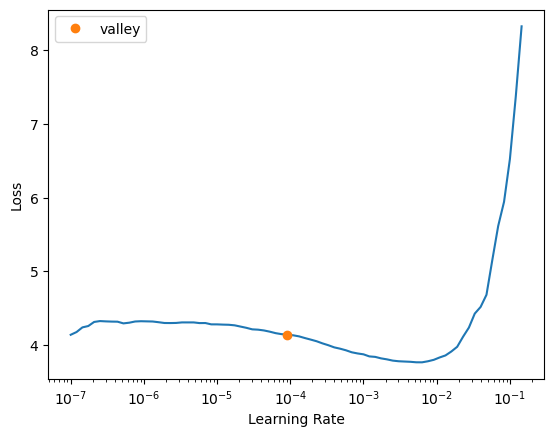

In [101]:
learn.lr_find()

In [102]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.106679,2.846926,0.457593,17.234720,04:13


In [103]:
df_valid.head(1)

,0
0,"\n = Tropical Storm <unk> ( 2008 ) = \n \n Tropical Storm <unk> was the tenth tropical storm of the 2008 Atlantic hurricane season . <unk> developed out of a strong tropical wave which moved off the African coast on August 31 . The wave quickly became organized and was declared Tropical Depression Ten while located 170 mi ( 270 km ) to the south @-@ southeast of the Cape Verde Islands on September 2 . The depression was quickly upgraded to Tropical Storm <unk> around noon the same day . Over the next several days , <unk> moved in a general west @-@ northwest direction and reached its peak..."


In [104]:
prompt = "\n = Unicorn = \n \n A unicorn is a magical creature with a rainbow tail and a horn"
tokenizer.pad_token = tokenizer.eos_token
inputs = tokenizer.encode_plus(prompt,\
                               return_tensors="pt",\
                               truncation=True
                              ).to("cuda:0")

In [105]:
preds = learn.model.generate(
  inputs['input_ids'], 
  attention_mask= inputs["attention_mask"],
  pad_token_id=tokenizer.eos_token_id,
  max_new_tokens=20
)

In [106]:
preds[0]

tensor([  198,   796, 39481,   796,   220,   198,   220,   198,   317, 44986,
          318,   257, 10883,  7185,   351,   257, 27223,  7894,   290,   257,
        12718,  2488,    12,    31,   588,  1182,   764,   632,   318,   257,
         2888,   286,   262,  1279,  2954,    29,  1641,   286, 28000, 19942,
          837], device='cuda:0')

In [107]:
tokenizer.decode(preds[0])

'\n = Unicorn = \n \n A unicorn is a magical creature with a rainbow tail and a horn @-@ like head . It is a member of the <unk> family of unicorns ,'